In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/meme-dataset/val_with_reason.csv
/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/No Hate/9273.png
/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/No Hate/9292.png
/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/No Hate/4353.png
/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/No Hate/6262.png
/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/No Hate/2664.png
/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/No Hate/9110.png
/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/No Hate/1231.png
/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/No Hate/1017.png
/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/No Hate/7530.png
/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/No Hate/85

2025-07-23 10:38:56.282928: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753267136.657002      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753267136.765915      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Checking images in train: 100%|██████████| 4050/4050 [00:05<00:00, 802.06it/s]


train: Removed 388 samples with missing images


Checking images in val: 100%|██████████| 506/506 [00:00<00:00, 842.15it/s]


val: Removed 0 samples with missing images


Checking images in test: 100%|██████████| 507/507 [00:00<00:00, 779.94it/s]


test: Removed 0 samples with missing images


tokenizer_config.json:   0%|          | 0.00/151 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Train dataset size: 3662
Validation dataset size: 506
Test dataset size: 507
Displaying Train Samples:


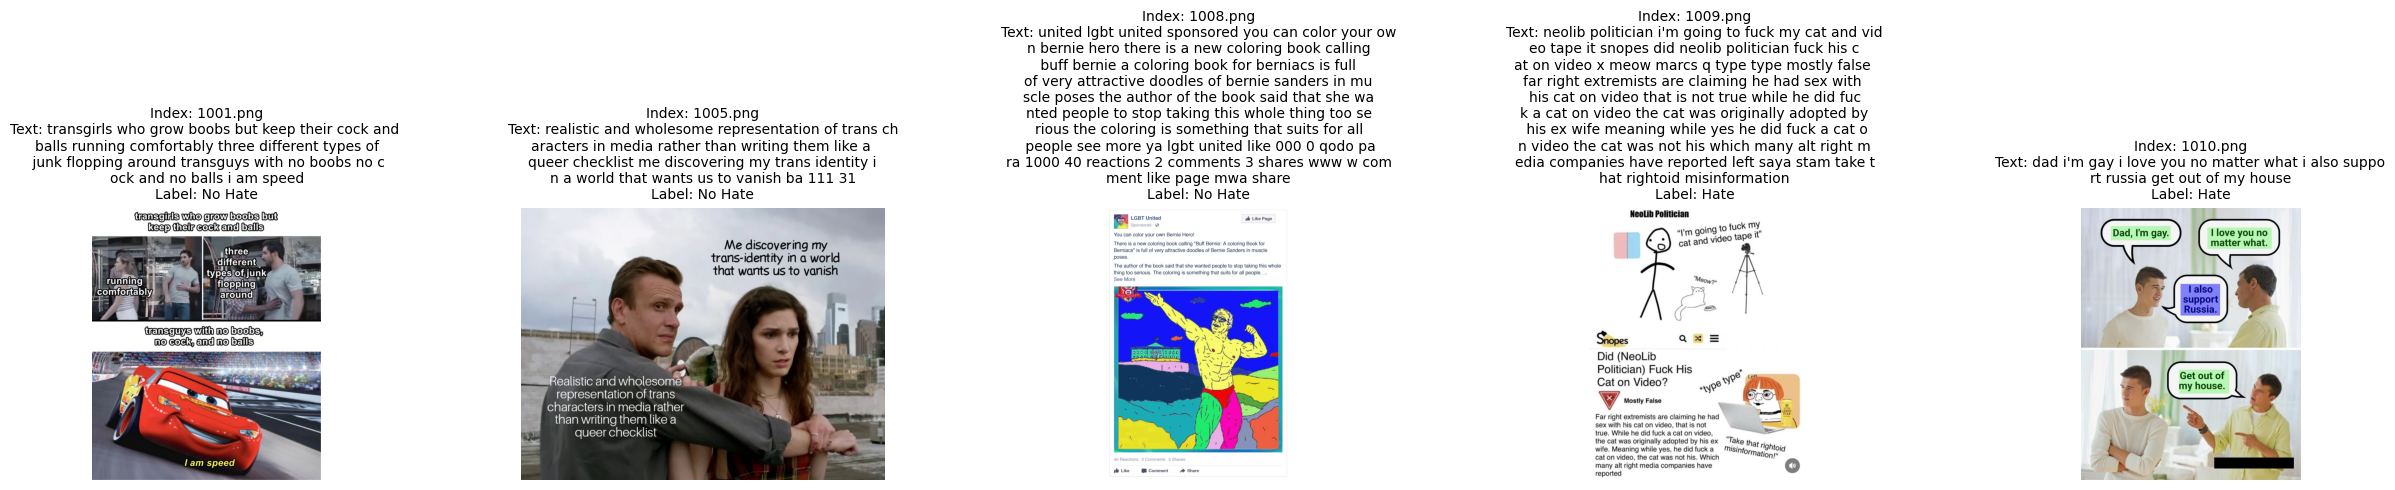


Displaying Validation Samples:


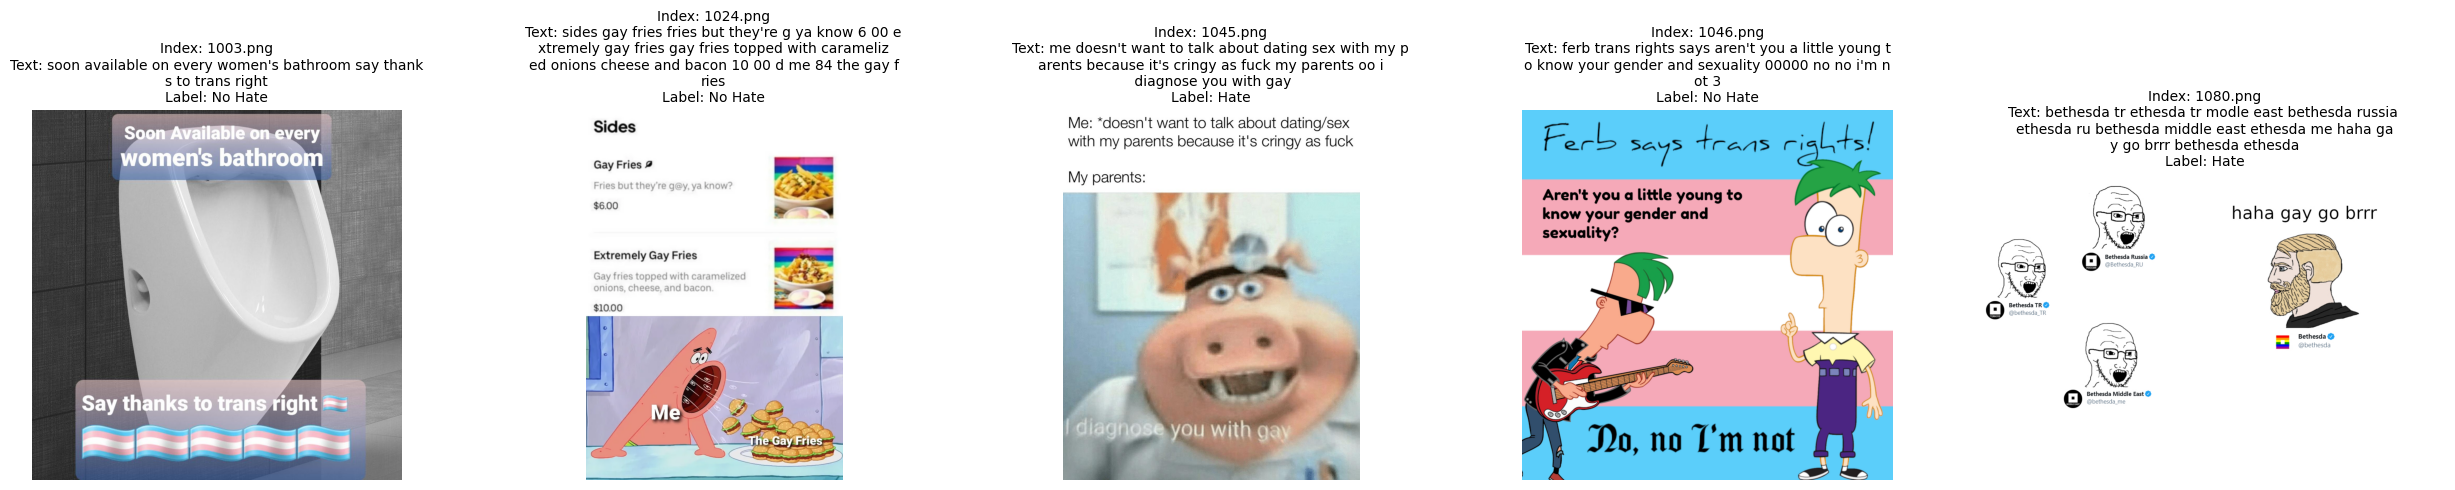


Displaying Test Samples:


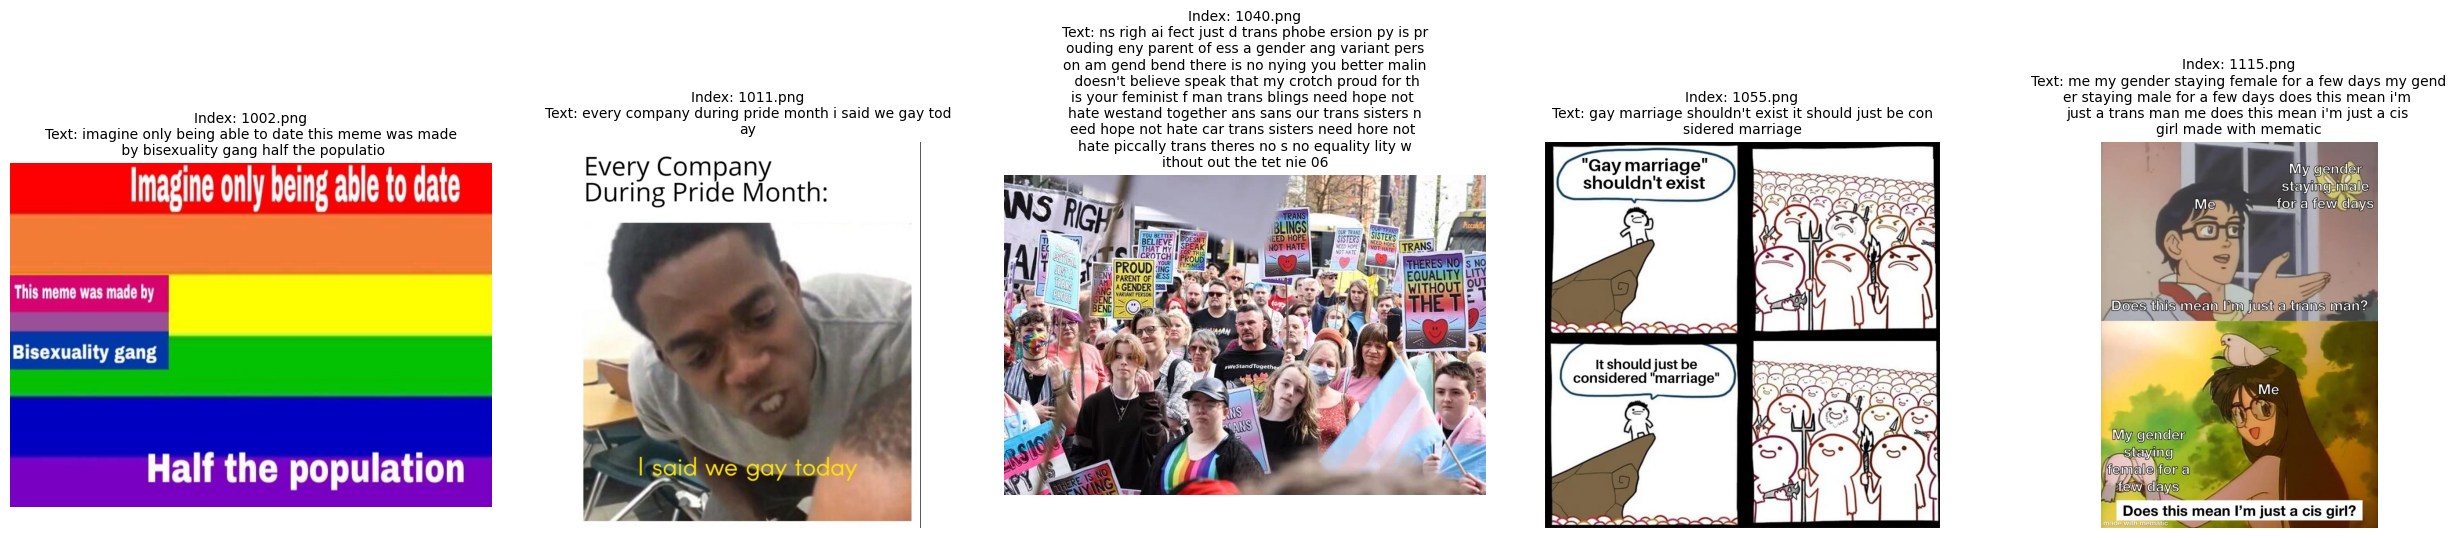

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, ViTModel
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import json
import zipfile

# Paths to datasets
image_base_path = "/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset"
train_csv = "/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Text_dataset/A_train.csv"
val_csv = "/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Text_dataset/A_val.csv"
test_csv = "/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Text_dataset/A_test.csv"

# Load datasets
train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)
test_df = pd.read_csv(test_csv)

# Construct image paths
def get_train_image_path(row):
    folder = "Hate" if row['label'] == 1 else "No Hate"
    return os.path.join(image_base_path, f"A_train_img/{folder}/{row['index']}")

train_df['image_path'] = train_df.apply(get_train_image_path, axis=1)
val_df['image_path'] = val_df['index'].apply(lambda x: os.path.join(image_base_path, f"A_val_img/{x}"))
test_df['image_path'] = test_df['index'].apply(lambda x: os.path.join(image_base_path, f"A_test_img/{x}"))

# Check for missing images and remove them
def filter_missing_images(df, name="dataset"):
    valid_rows = []
    missing_count = 0
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Checking images in {name}"):
        if os.path.exists(row['image_path']):
            valid_rows.append(row)
        else:
            missing_count += 1
    print(f"{name}: Removed {missing_count} samples with missing images")
    return pd.DataFrame(valid_rows).reset_index(drop=True)

train_df = filter_missing_images(train_df, "train")
val_df = filter_missing_images(val_df, "val")
test_df = filter_missing_images(test_df, "test")

# Text and image preprocessing
tokenizer = AutoTokenizer.from_pretrained("GroNLP/hateBERT")

def preprocess_text(text, max_length=128):
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    return encoding['input_ids'].squeeze(), encoding['attention_mask'].squeeze()

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom dataset
class MultimodalDataset(Dataset):
    def __init__(self, df, transform, is_test=False):
        self.df = df
        self.transform = transform
        self.is_test = is_test
        self.texts = df['text'].tolist()
        self.image_paths = df['image_path'].tolist()
        if not is_test:
            self.labels = df['label'].tolist()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.texts[idx]
        input_ids, attention_mask = preprocess_text(text)
        image = Image.open(self.image_paths[idx]).convert('RGB')
        image = self.transform(image)
        if self.is_test:
            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'image': image,
                'index': self.df['index'].iloc[idx]
            }
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'image': image,
            'label': torch.tensor(self.labels[idx], dtype=torch.float32)
        }

# Create datasets and dataloaders
train_dataset = MultimodalDataset(train_df, train_transform)
val_dataset = MultimodalDataset(val_df, val_test_transform)
test_dataset = MultimodalDataset(test_df, val_test_transform, is_test=True)

# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Function to display images with text
def display_samples(df, dataset_name, num_samples=5, is_test=False):
    samples = df.head(min(num_samples, len(df)))
    fig, axes = plt.subplots(1, num_samples, figsize=(5 * num_samples, 5))
    if num_samples == 1:
        axes = [axes]
    
    for i, (_, row) in enumerate(samples.iterrows()):
        image_path = row['image_path']
        image = Image.open(image_path).convert('RGB')
        axes[i].imshow(image)
        axes[i].axis('off')
        text = row['text']
        if is_test:
            title = f"Index: {row['index']}\nText: {text}"
        else:
            label = "Hate" if row['label'] == 1 else "No Hate"
            title = f"Index: {row['index']}\nText: {text}\nLabel: {label}"
        wrapped_text = "\n".join([text[j:j+50] for j in range(0, len(text), 50)])
        title = title.replace(text, wrapped_text)
        axes[i].set_title(title, fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Display samples from each dataset
print("Displaying Train Samples:")
display_samples(train_df, "train")
print("\nDisplaying Validation Samples:")
display_samples(val_df, "val")
print("\nDisplaying Test Samples:")
display_samples(test_df, "test", is_test=True)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# Multimodal model with late fusion
class MultimodalModel(nn.Module):
    def __init__(self):
        super(MultimodalModel, self).__init__()
        self.text_model = AutoModel.from_pretrained("GroNLP/hateBERT")
        self.image_model = ViTModel.from_pretrained("google/vit-base-patch16-224")
        self.fc = nn.Linear(768 * 2, 1)  # Late fusion: Concatenate 768-dim text and image embeddings
        self.dropout = nn.Dropout(0.3)  # Dropout for regularization

    def forward(self, input_ids, attention_mask, image):
        # Text embeddings
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_embeds = text_outputs.pooler_output  # [batch_size, 768]
        
        # Image embeddings
        image_outputs = self.image_model(pixel_values=image)
        image_embeds = image_outputs.pooler_output  # [batch_size, 768]
        
        # Late fusion: Concatenate text and image embeddings
        combined = torch.cat((text_embeds, image_embeds), dim=1)  # [batch_size, 768*2]
        combined = self.dropout(combined)  # Apply dropout
        
        # Classification
        logits = self.fc(combined)  # [batch_size, 1]
        return logits

# Initialize model, optimizer, and loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()



In [3]:
# Training loop
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask, images).squeeze()
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation function
def evaluate(model, loader):
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            
            logits = model(input_ids, attention_mask, images).squeeze()
            preds.extend(torch.sigmoid(logits).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    preds = [1 if p >= 0.5 else 0 for p in preds]
    accuracy = accuracy_score(true_labels, preds)
    f1 = f1_score(true_labels, preds, zero_division=0)
    precision = precision_score(true_labels, preds, zero_division=0)
    recall = recall_score(true_labels, preds, zero_division=0)
    return accuracy, f1, precision, recall

# Training loop
num_epochs = 10
best_val_acc = 0
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_acc, val_f1, val_precision, val_recall = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, "
          f"Val Accuracy = {val_acc:.4f}, Val F1 = {val_f1:.4f}, "
          f"Val Precision = {val_precision:.4f}, Val Recall = {val_recall:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pt")



Evaluating: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]


Epoch 1: Train Loss = 0.6190, Val Accuracy = 0.7470, Val F1 = 0.7229, Val Precision = 0.7804, Val Recall = 0.6734


Evaluating: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]


Epoch 2: Train Loss = 0.4304, Val Accuracy = 0.7470, Val F1 = 0.7388, Val Precision = 0.7479, Val Recall = 0.7298


Evaluating: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]


Epoch 3: Train Loss = 0.2238, Val Accuracy = 0.7253, Val F1 = 0.7495, Val Precision = 0.6775, Val Recall = 0.8387


Evaluating: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]


Epoch 4: Train Loss = 0.1005, Val Accuracy = 0.7510, Val F1 = 0.7640, Val Precision = 0.7133, Val Recall = 0.8226


Evaluating: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]


Epoch 5: Train Loss = 0.0607, Val Accuracy = 0.7549, Val F1 = 0.7395, Val Precision = 0.7719, Val Recall = 0.7097


Evaluating: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]


Epoch 6: Train Loss = 0.0332, Val Accuracy = 0.7490, Val F1 = 0.7475, Val Precision = 0.7373, Val Recall = 0.7581


Evaluating: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]


Epoch 7: Train Loss = 0.0318, Val Accuracy = 0.7431, Val F1 = 0.7471, Val Precision = 0.7218, Val Recall = 0.7742


Evaluating: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]


Epoch 8: Train Loss = 0.0256, Val Accuracy = 0.7352, Val F1 = 0.7373, Val Precision = 0.7176, Val Recall = 0.7581


Evaluating: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]


Epoch 9: Train Loss = 0.0177, Val Accuracy = 0.7510, Val F1 = 0.7539, Val Precision = 0.7311, Val Recall = 0.7782


Evaluating: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]


Epoch 10: Train Loss = 0.0296, Val Accuracy = 0.7589, Val F1 = 0.7645, Val Precision = 0.7333, Val Recall = 0.7984


In [4]:
# Test predictions
model.eval()
test_preds = []
test_indices = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        indices = batch['index']
        
        logits = model(input_ids, attention_mask, images).squeeze()
        preds = torch.sigmoid(logits).cpu().numpy()
        preds = [1 if p >= 0.5 else 0 for p in preds]
        test_preds.extend(preds)
        test_indices.extend(indices)



Predicting: 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]


In [5]:
# Create JSON Lines submission
submission_data = [{"index": f"{idx}.png", "prediction": pred} for idx, pred in zip(test_indices, test_preds)]
submission_data = sorted(submission_data, key=lambda x: int(x['index'].replace('.png', '')))
with open("submission.json", "w") as f:
    for entry in submission_data:
        f.write(json.dumps(entry) + "\n")
print("Test predictions saved to submission.json")

# Create ref.zip with submission.json
with zipfile.ZipFile("ref.zip", "w", zipfile.ZIP_DEFLATED) as zf:
    zf.write("submission.json")
print("Zipped submission.json into ref.zip")

Test predictions saved to submission.json
Zipped submission.json into ref.zip
